# Task Graphs Problem Formulation

In [170]:
using LightGraphs, MetaGraphs
using Parameters
using LinearAlgebra
using Compose
using Colors
using TaskGraphs
using GraphPlottingBFS
using DataStructures
using JuMP, MathOptInterface
# using GLPK
using Gurobi

In [50]:
function render_solution(r₀,s₀,sₜ,assignment;rad=5,width=20,fsize=10)
    robot_disks = [circle(p[1],p[2],rad) for p in r₀]
    object_disks = [rectangle(p[1]-rad,p[2]-rad,2*rad,2*rad) for p in s₀]
    c = cos(π/6)*rad; s = sin(π/6)*rad;
    object_disks = [polygon([(p[1]-c,p[2]+s),(p[1]+c,p[2]+s),(p[1],p[2]-rad)]) for p in s₀]
    station_disks = [rectangle(p[1]-rad,p[2]-rad,2*rad,2*rad) for p in sₜ]
    edge_list = []
    for i in 1:N+M
        for j in 1:M
            if assignment[i,j] == 1
                if i <= N
                    push!(edge_list, line([tuple(r₀[i]...),tuple(s₀[j]...)]))
                else
                    push!(edge_list, line([tuple(sₜ[i-N]...),tuple(s₀[j]...)]))
                end
                push!(edge_list, line([tuple(s₀[j]...),tuple(sₜ[j]...)]))
            end
        end
    end
    set_default_graphic_size((width)cm,(width)cm)
    compose(context(units=UnitBox(0,0,400,400)),
        compose(context(),
            [text(p[1],p[2],string(i),hcenter,vcenter) for (i,p) in enumerate(r₀)]...,
            stroke("black"),fontsize((fsize)pt), font("futura")),
        compose(context(),
            [text(p[1],p[2],string(i),hcenter,vcenter) for (i,p) in enumerate(s₀)]...,
            stroke("black"),fontsize((fsize)pt), font("futura")),
        compose(context(),
            [text(p[1],p[2],string(i),hcenter,vcenter) for (i,p) in enumerate(sₜ)]...,
            stroke("black"),fontsize((fsize)pt), font("futura")),
        compose(context(),robot_disks...,fill("cyan")),
        compose(context(),object_disks...,fill("orange")),
        compose(context(),station_disks...,fill("red")),
        compose(context(),edge_list...,stroke("gray"))
    )
end

render_solution (generic function with 1 method)

In [161]:
# solution graph encodes dependencies between robots and tasks too
function construct_solution_graph(G,assignment)
    M = nv(G)
    N = size(assignment,1) - M
    solution_graph = deepcopy(G)
    for j in vertices(solution_graph)
        set_prop!(G,j,:vtype,:task)
    end
    for i in 1:N+M
        add_vertex!(solution_graph,Dict(:vtype=>:robot))
    end
    for i in 1:N+M
        for j in 1:M
            if assignment[i,j] == 1
                add_edge!(solution_graph,M+i,j)
                add_edge!(solution_graph,j,M+j+N)
            end
        end
    end
    solution_graph
end

construct_solution_graph (generic function with 1 method)

In [120]:
function check_causality(assignment::Matrix)
    M = size(assignment,2)
    N = size(assignment,1) - M
    for i in 1:M
        for j in 1:M
            if assignment[i+N,j] == 1
                @assert(sum(assignment[:,j]) == 1)
            end
        end
    end
    return true
end

check_causality (generic function with 2 methods)

# Setup Problem

***
The `project_spec` describes:
1. the inputs, outputs and process time of operations that must be performed at manufacturing stations 
2. the dependencies between those operation (e.g. op 3 requires the outputs of op 1 and op 2

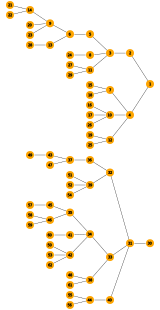

In [171]:
N = 120                  # num robots
M = 120                  # num delivery tasks
# project_spec = construct_random_project_spec(M;max_parents=3,depth_bias=1.0,Δt_min=0,Δt_max=0)
project_spec1 = construct_random_project_spec(Int(M/2);max_parents=3,depth_bias=0.25,Δt_min=0,Δt_max=0)
project_spec2 = construct_random_project_spec(Int(M/2);max_parents=3,depth_bias=0.25,Δt_min=0,Δt_max=0)
project_spec = combine_project_specs([project_spec1, project_spec2])
plot_graph_bfs(project_spec.graph;mode=nothing,fillcolor="orange")

***
The `delivery_graph` describes the delivery tasks that must be completed by robots in order to meet preconditions (objects 1 and 2 at station 3) for the prescribed operations

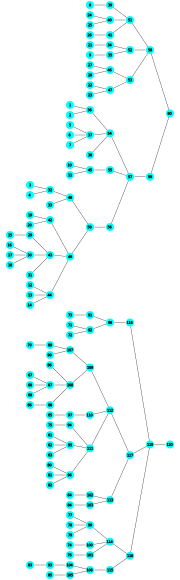

In [172]:
delivery_graph = construct_delivery_graph(project_spec,M)
r₀,s₀,sₜ = initialize_random_2D_task_graph_env(N,M;d=[400,400])
Drs, Dss = cached_pickup_and_delivery_distances(r₀,s₀,sₜ)
G = delivery_graph.graph
# initialize vector of operation times
Δt = zeros(nv(G)) # Δt[j] is the wait time for the object j to appear once all inputs have been satisfied
for op in project_spec.operations
    for id in get_output_ids(op)
        Δt[id] = duration(op)
    end
end
plot_graph_bfs(delivery_graph.graph;mode=nothing)

In [173]:
# set initial conditions
to0_ = Dict{Int,Float64}()
for v in vertices(G)
    if is_leaf_node(G,v)
        to0_[v] = 0.0
    end
end
tr0_ = Dict{Int,Float64}()
for i in 1:N
    tr0_[i] = 0.0
end

In [174]:
TaskGraphs.is_leaf_node(G,v) = length(inneighbors(G,v)) == 0

# Solve as MILP

In [176]:
model = formulate_JuMP_optimization_problem(G,Drs,Dss,Δt,to0_,tr0_,Gurobi.Optimizer;OutputFlag=0);
start_time = time()
optimize!(model)
solve_time = time() - start_time
optimal = (termination_status(model) == MathOptInterface.TerminationStatusCode(1))
@show solve_time
@show optimal;
assignment = Matrix{Int}(value.(model[:x]));

Academic license - for non-commercial use only
Academic license - for non-commercial use only
solve_time = 3.8248491287231445
optimal = true


In [186]:
spec = TaskGraphProblemSpec(N,M,G,Drs,Dss,Δt,tr0_,to0_)
cache = SearchCache(N,M,to0_,tr0_)
for j in 1:M
    i = findfirst(assignment[:,j] .== 1)
    cache.x[i,j] = 1
end
cache = process_solution(model,cache,spec);

In [119]:
check_causality(assignment)

true

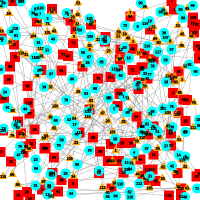

In [177]:
render_solution(r₀,s₀,sₜ,assignment;rad=10,width=20,fsize=10)

bfs_traversal = get_bfs_traversal(solution_graph) = [6, 5, 3, 7, 1, 4, 6, 5, 3, 7, 1, 4, 10, 6, 1, 9, 5, 3, 2, 6, 1, 9, 5, 2, 3, 8]


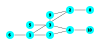

In [162]:
solution_graph = construct_solution_graph(G,assignment)
@show bfs_traversal = get_bfs_traversal(solution_graph);
plot_graph_bfs(solution_graph;mode=nothing)

In [ ]:
# r_frontier = Set{Int}(collect(1:N))
# r_explored = Set{Int}()
# t_frontier = Set{Int}()
# t_explored = Set{Int}()
# for j in 1:M
#     if is_leaf_node(G,j)
#         i = findfirst(assignment[:,j] .== 1)
#         if i <= N
#             push!(t_frontier, j)
#         end
#     end
# end
# while (length(t_frontier) > 0) || (length(r_frontier) > 0)
#     while length(t_frontier) > 0
#         j = pop!(t_frontier) # task id
#         for j2 in inneighbors(G,j) # parent tasks
#             cache.to0[j] = max(cache.to0[j], cache.tof[j2] + Δt[j])
#         end
#         i = findfirst(cache.x[:,j] .== 1) # robot id
#         if i in r_frontier
#             tro0 = cache.tr0[i] + Drs[i,j] # robot arrival time
#             cache.tof[j] = max(cache.to0[j], tro0) + Dss[j,j] # task completion time
#             cache.tr0[j+N] = cache.tof[j] # new robot availability time
#             push!(r_frontier, i+N)
#             push!(r_explored, i)
#             push!(t_explored, j)
#         end
#     end
#     while length(r_frontier) > 0
#         i = pop!(r_frontier) # robot id
#         if sum(cache.x[i,:]) == 0
#             continue
#         end
#         j = findfirst(cache.x[i,:] .== 1)
#         valid = true
#         for j2 in inneighbors(G,j) # parent tasks
#             valid = valid && (j2 in t_explored)
#             cache.to0[j] = max(cache.to0[j], cache.tof[j2] + Δt[j])
#         end
        
#     end
# end

In [159]:
struct BackupGraph{G,C,S}
    graph::G
    cache::C
    spec::S
end
LightGraphs.inneighbors(BG::BackupGraph,v) = inneighbors(BG.graph,v)
function GraphPlottingBFS.leaf_case!(BG::BackupGraph,j,s::BFS_state)
    if get_prop(solution_graph,j,:vtype) == :task
        @show i = findfirst(cache.x[:,j] .== 1) # robot id
        @show tro0 = BG.cache.tr0[i] + BG.spec.Drs[i,j] # robot arrival time
        @show BG.cache.tof[j] = max(BG.cache.to0[j], tro0) + BG.spec.Dss[j,j] # task completion time
        @show BG.cache.tr0[j+N] = BG.cache.tof[j] # new robot availability time
    end
    s = BFS_state(d=s.d,w=s.w+1,d_max=max(s.d_max,s.d))
end
function GraphPlottingBFS.initial_branch_case!(BG::BackupGraph,j,s::BFS_state)
    if get_prop(solution_graph,j,:vtype) == :task
    end
end
function GraphPlottingBFS.backup!(BG::BackupGraph,j,j2,s::BFS_state)
    if get_prop(solution_graph,j,:vtype) == :task
        @show BG.cache.to0[j] = max(cache.to0[j], cache.tof[j2] + Δt[j])
        @show i = findfirst(cache.x[:,j] .== 1) # robot id
        if BG.cache.tr0[i] < Inf
            @show tro0 = BG.cache.tr0[i] + BG.spec.Drs[i,j] # robot arrival time
            @show BG.cache.tof[j] = max(BG.cache.to0[j], tro0) + BG.spec.Dss[j,j] # task completion time
            @show BG.cache.tr0[j+N] = BG.cache.tof[j]
        end
    end
end

In [160]:
cache = SearchCache(N,M,to0_,tr0_);
for j in 1:M
    i = findfirst(assignment[:,j] .== 1)
    cache.x[i,j] = 1
end
spec = TaskGraphProblemSpec(N,M,G,Drs,Dss,Δt,tr0_,to0_)
BG = BackupGraph(G,cache,spec);
for j in get_all_root_nodes(G)
    bfs!(BG,j,BFS_state())
end
BG.cache.tof

i = findfirst(cache.x[:, j] .== 1) = 3
i = findfirst(cache.x[:, j] .== 1) = 1
tro0 = (BG.cache).tr0[i] + (BG.spec).Drs[i, j] = 225.0
(BG.cache).tof[j] = max((BG.cache).to0[j], tro0) + (BG.spec).Dss[j, j] = 759.0
(BG.cache).tr0[j + N] = (BG.cache).tof[j] = 759.0
(BG.cache).to0[j] = max(cache.to0[j], cache.tof[j2] + Δt[j]) = 759.0
i = findfirst(cache.x[:, j] .== 1) = 5
tro0 = (BG.cache).tr0[i] + (BG.spec).Drs[i, j] = 866.0
(BG.cache).tof[j] = max((BG.cache).to0[j], tro0) + (BG.spec).Dss[j, j] = 1237.0
(BG.cache).tr0[j + N] = (BG.cache).tof[j] = 1237.0
i = findfirst(cache.x[:, j] .== 1) = 2
tro0 = (BG.cache).tr0[i] + (BG.spec).Drs[i, j] = 548.0
(BG.cache).tof[j] = max((BG.cache).to0[j], tro0) + (BG.spec).Dss[j, j] = 874.0
(BG.cache).tr0[j + N] = (BG.cache).tof[j] = 874.0
(BG.cache).to0[j] = max(cache.to0[j], cache.tof[j2] + Δt[j]) = 874.0


4-element Array{Float64,1}:
  874.0
 1237.0
  759.0
    0.0

In [187]:
cache.tof

120-element Array{Float64,1}:
  423.0             
  506.99999999999955
  400.9999999999998 
  123.99999999999955
  328.9999999999993 
  385.0             
  162.0             
  125.99999999999932
  266.0             
  682.9999999999995 
  342.99999999999955
  283.99999999999966
  188.99999999999955
    ⋮               
 1140.9999999999998 
  590.9999999999991 
 1008.9999999999997 
 1567.0000000000005 
 1427.0             
 1247.9999999999995 
  935.9999999999991 
 1221.999999999999  
 1776.0             
 1775.9999999999995 
 1890.9999999999989 
 2203.999999999998  

In [182]:
function process_solution(model,cache::SearchCache,spec::TaskGraphProblemSpec)
    Drs, Dss, Δt, N, G = spec.Drs, spec.Dss, spec.Δt, spec.N, spec.graph
    
#     solution_graph = construct_solution_graph(G,cache.x)
#     bfs_traversal = Vector{Int}()
#     for v in get_all_root_nodes(solution_graph)
#         if get_prop(solution_graph,v,:vtype) == :task
#             bfs_traversal = [bfs_traversal..., get_bfs_node_traversal(solution_graph,v)...]
#         end
#     end
#     # Compute Lower Bounds Via Forward Dynamic Programming pass
#     for v in bfs_traversal
#         if get_prop(solution_graph,v,:vtype) == :task
#             for v2 in inneighbors(G,v)
#                 cache.to0[v] = max(cache.to0[v], cache.tof[v2] + Δt[v])
#             end
#             xi = findfirst(cache.x[:,v] .== 1)
#             tro0 = cache.tr0[xi] + Drs[xi,v]
#             cache.tof[v] = max(cache.to0[v], tro0) + Dss[v,v]
#             cache.tr0[v+N] = cache.tof[v]
#         elseif get_prop(solution_graph,v,:vtype) == :robot

#         end
#     end
    # Compute Slack Via Backward Dynamic Programming pass
#     for v in reverse(bfs_traversal)
#         if get_prop(solution_graph,v,:vtype) == :task
#             for v2 in inneighbors(G,v)
#                 if get_prop(solution_graph,v2,:vtype) == :task
#                     cache.local_slack[v2] = cache.to0[v] - cache.tof[v2]
#                     cache.slack[v2]       = cache.slack[v] + cache.local_slack[v2]
#                 end
#             end
#         end
#     end
#     cache
    cache.tr0[:] = value.(model[:tr0])
    cache.to0[:] = value.(model[:to0])
    cache.tof[:] = value.(model[:tof])
    for v in reverse(get_bfs_traversal(G))
        for v2 in inneighbors(G,v)
            cache.local_slack[v2] = cache.to0[v] - cache.tof[v2]
            cache.slack[v2]       = cache.slack[v] + cache.local_slack[v2]
        end
    end
    cache
end

# Solve assignment problem with Dynamic Programming

Two possible search paradigms:
1. Start with the lower bound infeasible solution, then add constraints via branch-and-bound until the first feasible (and therefore the optimal) solution is returned. One major issue with this approach is that it may take a VERY long time to get through all of the low-cost but infeasible solutions.
2. Start with a greedy solution and improve it until it can't be improved anymore. This paradigm comes with two questions: (a) How to know that a solution can't be improved? (b) How to guarantee global optimality (e.g. how to start in the right "basin of attraction")?

I think it would be good to start tracking the slack associated with dummy robots as well

In [ ]:
start_time = time()
cache, FEASIBLE = solve_task_graphs_problem(G,Drs,Dss,Δt,to0_,tr0_;mode=1,MAX_ITERS=100000)
solve_time = time() - start_time

@show solve_time 
@show cache.tof
@show cache.slack
@show cache.local_slack;

# MATROID SEARCH!!!!!!!

1. First lesson learned: the dimensionality of the matroid table scales exponentially with problem size. I will have to use a sparse lookup table.

In [ ]:
function get_matroid_table_dimension(n::Int)
    N = 2^n
end

In [ ]:
struct AssignmentSeries
    robot::Int
    tasks::Vector{Int}
end
struct PartialAssignment
    assignments::Set{AssignmentSeries}
end
struct SearchState
    robot_x::Vector{Int} # indices giving robot locations
    robot_t::Vector{Float64} # indices giving robot availability times
    assignments::Vector{AssignmentSeries}
end
struct AssignmentMatroid
    robots::Set{Int}
    tasks::Set{Int}
end
const SearchTable = Dict{Int,Vector{AssignmentSeries}}
function SearchTable(N::Int)
    SearchTable( i => Vector{AssignmentSeries}() for i in 1:N)
end
const AssignmentQueues = Dict{Int,PriorityQueue{AssignmentSeries,Float64}}
function AssignmentQueues(M::Int)
    AssignmentQueues(j=>PriorityQueue{AssignmentSeries,Float64}() for j in 1:M)
end

In [ ]:
# assignment_queues = AssignmentQueues(M)
# for j in 1:M
#     q = assignment_queues[j]
#     if is_leaf_node(G,j)
#         for i in 1:N
#             assignment = AssignmentSeries(i,[j])
#             tof = max(to0_[j], tr0_[i] + Drs[i,j]) + Dss[j,j]
#             enqueue!(q,assignment=>tof)
#         end
#     end
# end

In [ ]:
# n = 4; m = 7
# N = get_matroid_table_dimension(n)
# M = get_matroid_table_dimension(m)
# search_table = SearchTable(n)

# Sandbox

In [ ]:
bfs_traversal = get_bfs_node_traversal(G);
cache = SearchCache(N,M,to0_,tr0_)
for j in 1:M
    upstream_jobs = [j, map(e->e.dst,collect(edges(bfs_tree(G,j;dir=:in))))...]
    for v in upstream_jobs
        add_constraint!(cache.FT, j+N, v)
    end
end
spec = TaskGraphProblemSpec(N,M,Drs,Dss,tr0_,to0_)

cache = solve_task_graph(cache,spec,bfs_traversal)

In [ ]:
stacked_vals = [cache.tr0;cache.to0;cache.tof;cache.slack]
for j in 1:M
    cache = deepcopy(cache)
    for i in 1:N+M
        if cache.x[i] == 1
            add_constraint!(cache.FT, i, j)
        end
    end
    cache = solve_task_graph(cache,spec,bfs_traversal)
    stacked_vals = hcat(stacked_vals, [cache.tr0;cache.to0;cache.tof;cache.slack])
end
stacked_vals

In [ ]:
cache.FT.arr

In [ ]:
j = 1
idxs = findall(cache.x[j,:] .== 1)
ordering = (cache.slack .* cache.x[j,:])[idxs]
sorted_idxs = sort(idxs, by=i->(cache.slack .* cache.x[j,:])[i])
@show idxs
@show ordering
@show sorted_idxs;

In [ ]:
cr_path = get_critical_path(bfs_traversal,slack)
@show slack
@show local_slack
@show cr_path
plot_graph_bfs(delivery_graph.graph;mode=nothing)

# Comparisons

In [ ]:
N = 5                  # num robots
M = 10                 # num delivery tasks
r₀,s₀,sₜ = initialize_random_2D_task_graph_env(N,M;d=[40,40])
Drs, Dss = cached_pickup_and_delivery_distances(r₀,s₀,sₜ)
project_spec = construct_random_project_spec(M;max_parents=3,depth_bias=1.0,Δt_min=0,Δt_max=0)

delivery_graph = construct_delivery_graph(project_spec,M)
G = delivery_graph.graph
# initialize vector of operation times
Δt = zeros(nv(G)) # Δt[j] is the wait time for the object j to appear once all inputs have been satisfied
for op in project_spec.operations
    for id in get_output_ids(op)
        Δt[id] = duration(op)
    end
end

# set initial conditions
to0_ = Dict{Int,Float64}()
for v in vertices(G)
    if is_leaf_node(G,v)
        to0_[v] = 0.0
    end
end
tr0_ = Dict{Int,Float64}()
for i in 1:N
    tr0_[i] = 0.0
end
# plot_graph_bfs(delivery_graph.graph;mode=nothing)

# Sandbox

In [ ]:
# @show backward_slack;
########### Compute Greedy Solution ###########
# sorted lists of assignment time
A = Vector{Vector{Int}}() #[collect(1:N+M) for j in 1:M])
D_ = Drs .+ tr0_low
for j in 1:M
    push!(A, sortperm(Drs[:,j]+tr0_low)) # sort robot ids by lower bound on arrival time
    D_[:,j] = D_[:,j] .- Drs[A[j][1],j]
end
# ### Try to find an optimal assignment working forward
# Push open nodes into a priority queue, where priority is defined by slack
p = PriorityQueue{Int,Float64}()
for v in vertices(G)
    if is_leaf_node(G,v)
        enqueue!(p,v=>slack[v])
    end
end
# Iteratively compute assignments by moving through the graph from the bottom up
x = Dict{Int,Int}() # j=>i maps task j => robot i
assigned = Set{Int}()
# While an optimal solution has not yet been returned
while length(p) > 0
    # Pop an open node from the queue and make an assignment (greedy vs. selfless...)
    j, dt = dequeue_pair!(p)
    # find the best robot for the job
    for i in A[j]
        
    end
    a = A[j]
    d = Int.(round.(D_[:,j][A[j]]))
    @show j
    @show a
    @show d
end
#     1. If the greedy assignment is already taken and the next assignment maintains non-negative slack, continue to the next assignment.
#     2. If the greedy assignment maintains the current critical path, keep it
#     3. If the greedy assignment ... 
#     4. return to 2

In [ ]:
bfs_traversal = bfs_tree(G,M;dir=:in)
ids = map(e->e.dst, collect(edges(bfs_traversal)))
p = PriorityQueue{Int,Float64}()
for v in vertices(G)
    if is_leaf_node(G,v)
        enqueue!(p,v=>slack[v])
    end
end

# Next steps:

- How to solve the planning problem? I have a vague idea for a
  forward-backward BFS algorithm with pruning.
- It may be helpful to compute the slack in both directions
- When lots of projects are happening in the factory at once, this will
  converge to a sort of steady-state thing. How to formulate this on a
  receding horizon basis? Initial thoughts: problem statement is defined
  by available time of robots (0 for robots with no payload, scheduled
  dropoff time for robots with a payload), graph(s), distance matrix and
  process time vector $\Delta t$. Also, the right approach for massive 
  scaling may be a prioritized planning approach.

In [ ]:
assignments = Dict{Int,Int}() # j=>i maps task j => robot i
while length(p) > 0
    j, dt = dequeue_pair!(p)
end